In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
import sys

sys.path.append('../')

import csv
import numpy as np
import sys
import scipy.ndimage as nd
import json
import pickle
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.transforms import Resize
from torch.utils.data import Dataset, DataLoader
from models.resnet import *
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import time
import math
from utils.utils import AverageMeter
from datasets.Preprocess_2D import Slice2D_DataPreprocess
from train.train_2d_cls2 import test

import torch.nn.functional as F

import scipy.ndimage as nd
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
config_file = '../config/config_2D.json'
with open(config_file,encoding='gb2312') as f:
    config = json.load(f)
config

{'train_list_file': '',
 'val_list_file': '',
 'test_list_file': '',
 'model_dir': '',
 'num_classes': 2,
 'phase': 'train',
 'model': 'resnet34',
 'weight': None,
 'lr': 0.001,
 'mom': 0.9,
 'wd': 0.0001,
 'fix': 50,
 'step': 20,
 'epoch': 120,
 'display': 100,
 'num_workers': 8,
 'batch_size': 12,
 'dim_z': 128,
 'dim_x': 128,
 'optimizer': 'sgd'}

In [3]:
batch_size = 4
num_workers = 4
phase = 'train'
epochs = 10000
display = 2
data_transforms = transforms.Compose([
#         transforms.Resize((512,512)),
        transforms.ToTensor(),
    ]) 

In [4]:
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(512, 2)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# data_type = 'phase1'
# weights = '../data/aug2D/slice_phase1_exp2/phase1_0.5981308411214953_2_Fattyliver.pth' #0.6358
# weights = '/home/zhangwd/code/work/FattyLiver_Solution/data/aug2D/slice_phase1_exp2/phase1_0.7102803738317757_23_Fattyliver.pth'#0.5906

# data_type = 'phase2'
# weights = '../data/aug2D/slice_phase2_exp2/phase2_0.5887850467289719_44_Fattyliver.pth'#0.5891

data_type = 'diff'
# weights = '../data/aug2D/slice_diff_exp2/diff_0.6074766355140186_11_Fattyliver.pth' #0.5646
weights = '../data/aug2D/slice_diff_exp2/diff_0.6355140186915887_30_Fattyliver.pth'

#after crop
# data_type = 'phase1'
# weights = '../data/aug2D/slice_crop_phase1_exp2/phase1_0.5981308411214953_39_Fattyliver.pth'#0.6858

# data_type = 'phase2'
# weights = '../data/aug2D/slice_crop_phase2_exp2/phase2_0.5981308411214953_47_Fattyliver.pth' #0.6038

# data_type = 'diff'
# weights = '../data/aug2D/slice_crop_diff_exp2/diff_0.616822429906542_53_Fattyliver.pth' #0.4651


model.load_state_dict(torch.load(weights))

<All keys matched successfully>

In [5]:
data_root = '/home/zhangwd/code/work/FattyLiver_Solution/data/experiment_slice/train/{}'.format(data_type)
config_test = '../data/config/config_train.txt'

test_ds = Slice2D_DataPreprocess(data_root, data_type, config_test, data_transforms)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                                    num_workers=num_workers, pin_memory=False)

====> fatty liver count is:747


In [6]:
criterion = nn.CrossEntropyLoss().cuda()
acc, logger, tot_pred, tot_label, tot_prob = test(test_dataloader, nn.DataParallel(model).cuda(), criterion, 0, 15)
print(acc)
# print(tot_prob)

../train/train_2d_cls2.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  tot_prob = np.append(tot_prob, F.softmax(output).cpu().detach().numpy()[:,1])


Epoch: [0][14/187]	Time 0.034086 (3.671)	Data 0.016	Loss 0.3829	Accuray 0.9500
Epoch: [0][29/187]	Time 0.029229 (1.850)	Data 0.009	Loss 0.6254	Accuray 0.7083
Epoch: [0][44/187]	Time 0.029531 (1.243)	Data 0.007	Loss 0.5805	Accuray 0.7222
Epoch: [0][59/187]	Time 0.028064 (0.940)	Data 0.006	Loss 1.0418	Accuray 0.7000
Epoch: [0][74/187]	Time 0.026386 (0.758)	Data 0.005	Loss 0.9270	Accuray 0.7433
Epoch: [0][89/187]	Time 0.022082 (0.636)	Data 0.005	Loss 0.9377	Accuray 0.7194
Epoch: [0][104/187]	Time 0.026182 (0.550)	Data 0.005	Loss 0.9506	Accuray 0.7167
Epoch: [0][119/187]	Time 0.029393 (0.484)	Data 0.005	Loss 0.8886	Accuray 0.7250
Epoch: [0][134/187]	Time 0.028078 (0.434)	Data 0.004	Loss 0.8429	Accuray 0.7315
Epoch: [0][149/187]	Time 0.029779 (0.393)	Data 0.004	Loss 0.8181	Accuray 0.7267
Epoch: [0][164/187]	Time 0.025050 (0.361)	Data 0.004	Loss 0.8256	Accuray 0.7030
Epoch: [0][179/187]	Time 0.029540 (0.333)	Data 0.004	Loss 0.8244	Accuray 0.6806
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0

In [7]:
def acu_curve(y,prob):
    from sklearn import metrics
    fpr,tpr,threshold = metrics.roc_curve(y,prob) ###计算真正率和假正率
    roc_auc = metrics.auc(fpr,tpr) ###计算auc的值
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic train')
    plt.legend(loc="lower right")
 
    plt.show()


def plot_roc(y_true, y_pred, class_name='dr'):
    print('\n====> plot {} info:\n'.format(class_name))
    log = []
    from sklearn import metrics
    def calc_metrics_table(y_true, y_pred, thresholds):
        metrics_list = list()
        for threshold in thresholds:
            y_pred_binary = np.zeros(y_pred.shape, dtype=np.uint8)
            y_pred_binary[y_pred>threshold] = 1
            tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred_binary).ravel()
#             print('tn:{:.3f}\tfp:{:.3f}\tfn:{:.3f}\ttp:{:.3f}\t'.format(tn, fp, fn, tp))
            accuracy = (tp+tn)/(tn+fp+fn+tp)
            sensitivity = tp/(tp+fn)
            specificity = tn/(fp+tn)
            ppv = tp/(tp+fp)
            npv = tn/(tn+fn)
            metrics_list.append([threshold, accuracy, sensitivity, specificity, ppv, npv])
        metrics_table = pd.DataFrame(np.array(metrics_list), columns=['threshold','accuracy','sensitivity','specificity','ppv','npv'])
        return metrics_table


    fpr, tpr, thres = metrics.roc_curve(y_true, y_pred)
    print('fpr\t\t\t','tpr')
    for i in range(len(fpr)):
        print(fpr[i],'\t',tpr[i])

    auc = metrics.auc(fpr, tpr)

    thresholds = np.arange(0.01, 1., 0.01)
    metrics_table = calc_metrics_table(y_true, y_pred, thresholds)

    print('\nAUC:%.4f\n'% auc)
    log.append('AUC:%.4f'% auc)

#     plt.figure()
#     plt.title('{} roc curve'.format(class_name))
#     plt.plot(fpr, tpr, 'r')
#     plt.xlabel('fpr')
#     plt.ylabel('tpr')
#     plt.xticks(np.arange(0, 1.1, step=0.1))
#     plt.yticks(np.arange(0, 1.1, step=0.1))
#     plt.grid(ls='--')
#     plt.show()
    acu_curve(y_true, y_pred)

    print(metrics_table)
    log.append(metrics_table)
    
    metrics_table.to_csv('/home/zhangwd/code/work/FattyLiver_Solution/train/Train_2D_0.716.txt.csv')

    return log


====> plot fatty liver classification 2 info:

fpr			 tpr
0.0 	 0.0
0.0 	 0.002398081534772182
0.0 	 0.04316546762589928
0.0030303030303030303 	 0.04316546762589928
0.0030303030303030303 	 0.09352517985611511
0.006060606060606061 	 0.09352517985611511
0.006060606060606061 	 0.09832134292565947
0.012121212121212121 	 0.09832134292565947
0.012121212121212121 	 0.10071942446043165
0.015151515151515152 	 0.10071942446043165
0.015151515151515152 	 0.11750599520383694
0.01818181818181818 	 0.11750599520383694
0.01818181818181818 	 0.1223021582733813
0.021212121212121213 	 0.1223021582733813
0.021212121212121213 	 0.12470023980815348
0.024242424242424242 	 0.12470023980815348
0.024242424242424242 	 0.14148681055155876
0.02727272727272727 	 0.14148681055155876
0.02727272727272727 	 0.1486810551558753
0.030303030303030304 	 0.1486810551558753
0.030303030303030304 	 0.18225419664268586
0.03333333333333333 	 0.18225419664268586
0.03333333333333333 	 0.2014388489208633
0.03636363636363636 	 0.201

<Figure size 432x288 with 0 Axes>

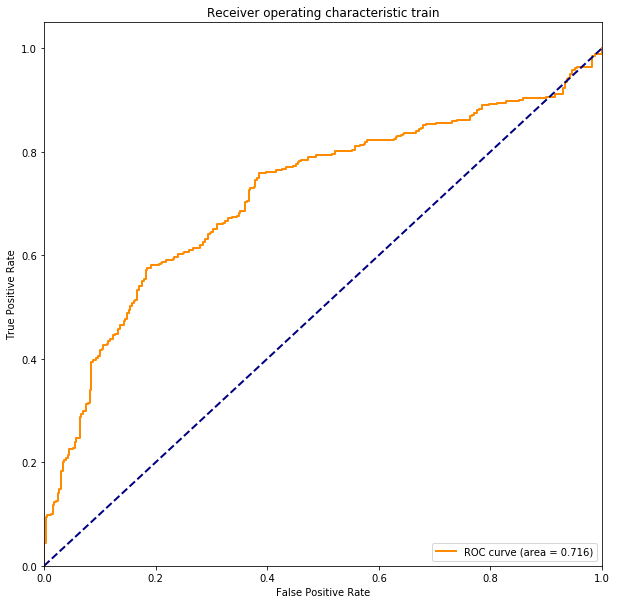

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.01  0.548862     0.968825     0.018182  0.554945  0.315789
1        0.02  0.546185     0.964029     0.018182  0.553719  0.285714
2        0.03  0.546185     0.964029     0.018182  0.553719  0.285714
3        0.04  0.547523     0.964029     0.021212  0.554483  0.318182
4        0.05  0.547523     0.964029     0.021212  0.554483  0.318182
..        ...       ...          ...          ...       ...       ...
94       0.95  0.468541     0.050360     0.996970  0.954545  0.453793
95       0.96  0.464525     0.040767     1.000000  1.000000  0.452055
96       0.97  0.457831     0.028777     1.000000  1.000000  0.448980
97       0.98  0.456493     0.026379     1.000000  1.000000  0.448370
98       0.99  0.449799     0.014388     1.000000  1.000000  0.445344

[99 rows x 6 columns]


In [8]:
log = plot_roc(np.array(tot_label, dtype=np.float32), np.array(tot_prob), 'fatty liver classification 2')